# Prédiction de Salaires - Régression Linéaire Multiple

## Objectif
Ce notebook présente une analyse complète de régression linéaire multiple pour prédire les salaires des employés.

## Plan d'analyse
1. **Exploration des données**
2. **Préparation des données**
3. **Modélisation**
   - Baseline avec DummyRegressor
   - Régression linéaire simple
4. **Réugularisation avec GridSearchCV**
   - Ridge Regression (L2)
   - Lasso Regression (L1)
6. **Résumé et Comparaison Finale**

In [16]:
# Import des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.impute import SimpleImputer
import warnings
import os
print(os.getcwd())        # doit être .../linear-regression-exercise-master
# Si besoin, changer:
# os.chdir('/Users/mathissaintalbin/Desktop/test git/linear-regression-exercise-master')
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

/Applications/dossier sans titre 2/projet 1/linear-regression-exercise


## 1. Chargement et Exploration des Données

In [17]:
# Chargement des données

# TO DO : Charger le dataset employee_salaries.csv dans un DataFrame pandas et afficher les 5 premières lignes ainsi que la shape du dataset
# Chargement des données
from pathlib import Path

csv_path = Path('data') / 'employee_salaries.csv'
df = pd.read_csv(csv_path)

# Affichage des 5 premières lignes
print("Les 5 premières lignes du dataset :")
print(df.head())

# Affichage de la forme du dataset
print("\nForme du dataset :", df.shape)


Les 5 premières lignes du dataset :
   age  experience  education_years  heures_semaine  nb_projets  \
0   38           5                0              39         3.0   
1   29           0                1              35         1.0   
2   25           1                0              37         0.0   
3   25           1                4              40         3.0   
4   37           5                1              41         7.0   

   evaluation_performance  anciennete_entreprise niveau_education departement  \
0                     2.9                      2              Bac   Marketing   
1                     4.6                      0              Bac     Finance   
2                     4.4                      0              Bac         R&D   
3                     7.4                      0           Master      Ventes   
4                     5.0                      0              Bac          IT   

    poste     ville   secteur  taille_entreprise  salaire_annuel  
0  Seni

In [18]:
# Informations sur le dataset et statistiques descriptives
# Informations sur le dataset et statistiques descriptives
# Affichage des informations sur le dataset
print("\nInformations sur le dataset :")
print(df.info())

# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())

# Nombre de valeurs manquantes par colonne
print("\nNombre de valeurs manquantes par colonne :")
print(df.isnull().sum())
# TO DO : Afficher les informations statistiques sur le dataset ainsi que le nombre de valeurs manquantes par colonne


Informations sur le dataset :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     10000 non-null  int64  
 1   experience              10000 non-null  int64  
 2   education_years         10000 non-null  int64  
 3   heures_semaine          10000 non-null  int64  
 4   nb_projets              9900 non-null   float64
 5   evaluation_performance  9800 non-null   float64
 6   anciennete_entreprise   10000 non-null  int64  
 7   niveau_education        10000 non-null  object 
 8   departement             10000 non-null  object 
 9   poste                   10000 non-null  object 
 10  ville                   10000 non-null  object 
 11  secteur                 10000 non-null  object 
 12  taille_entreprise       10000 non-null  object 
 13  salaire_annuel          10000 non-null  float64
dtypes: float

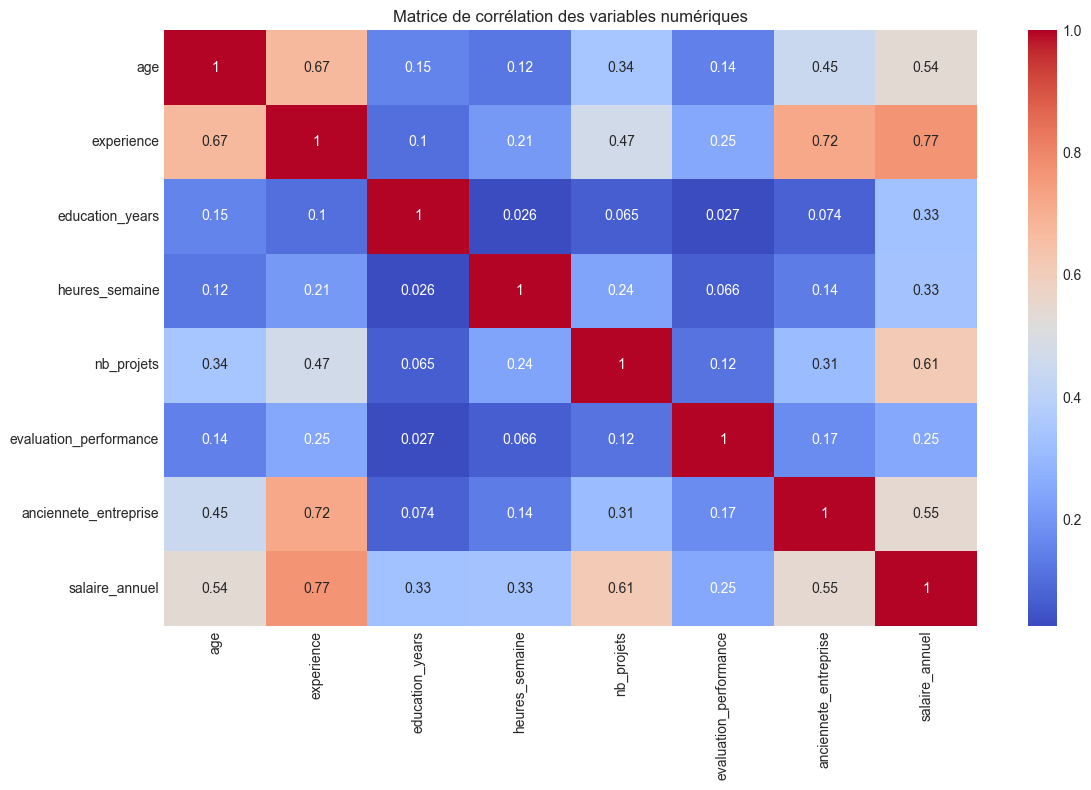

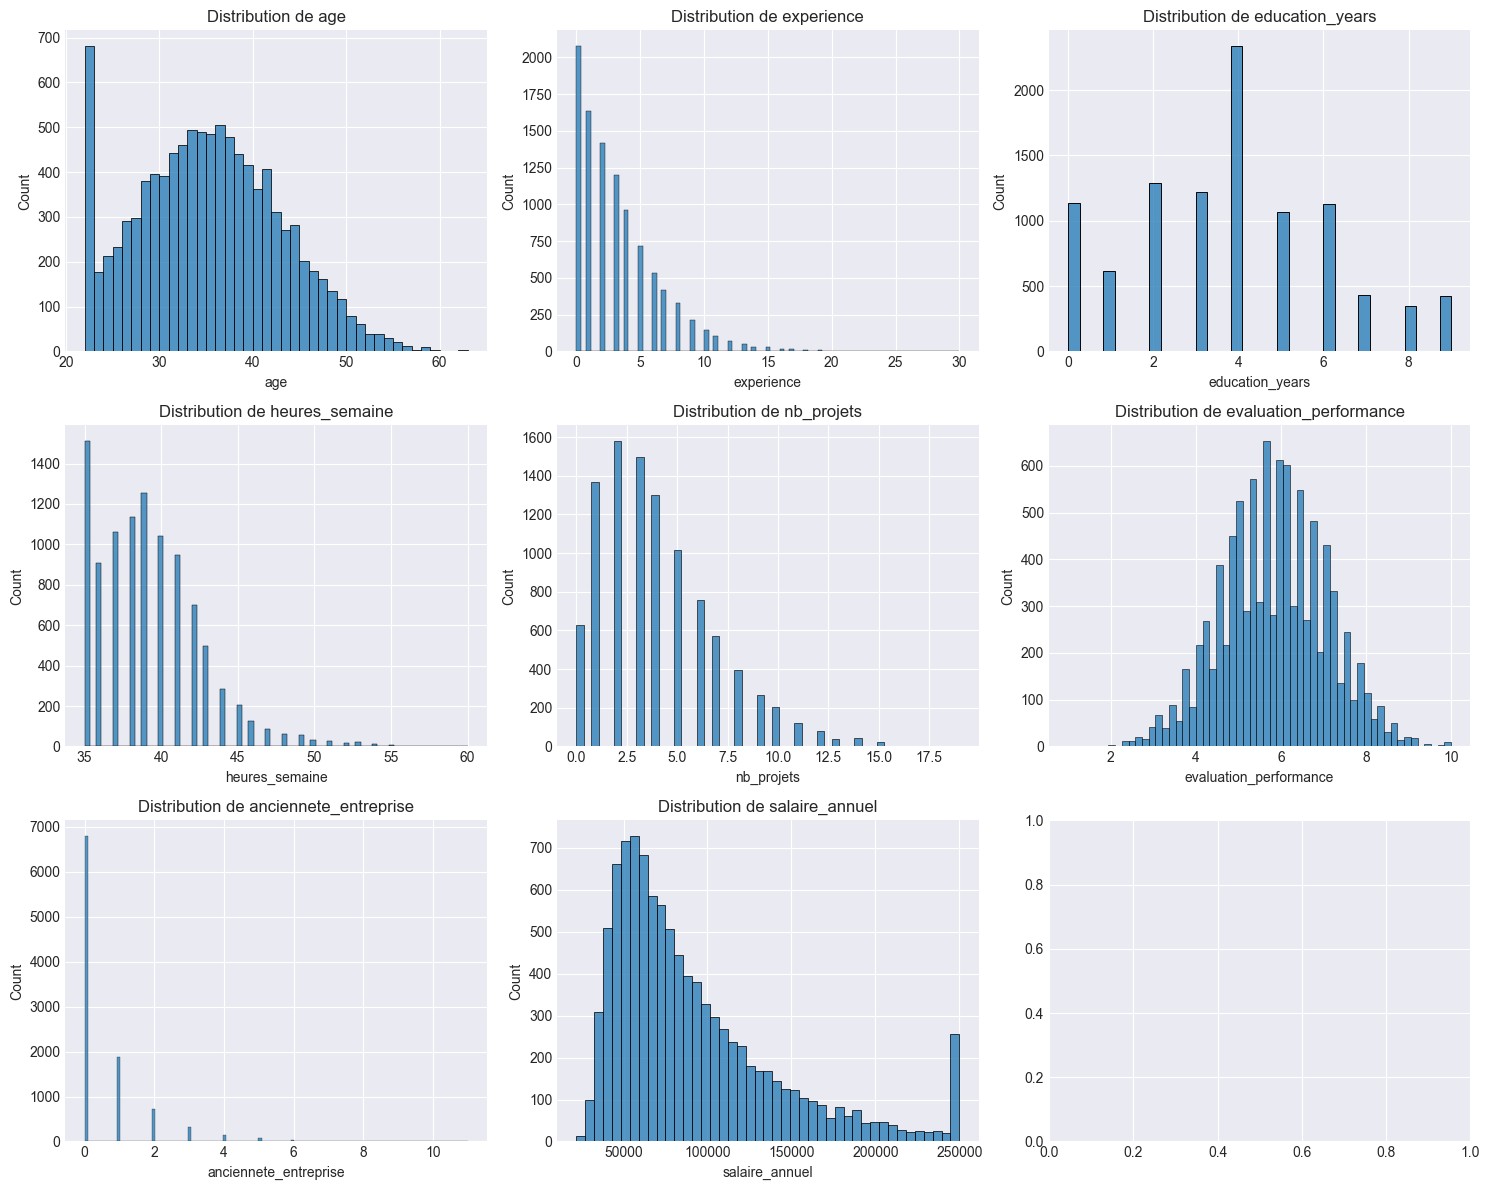

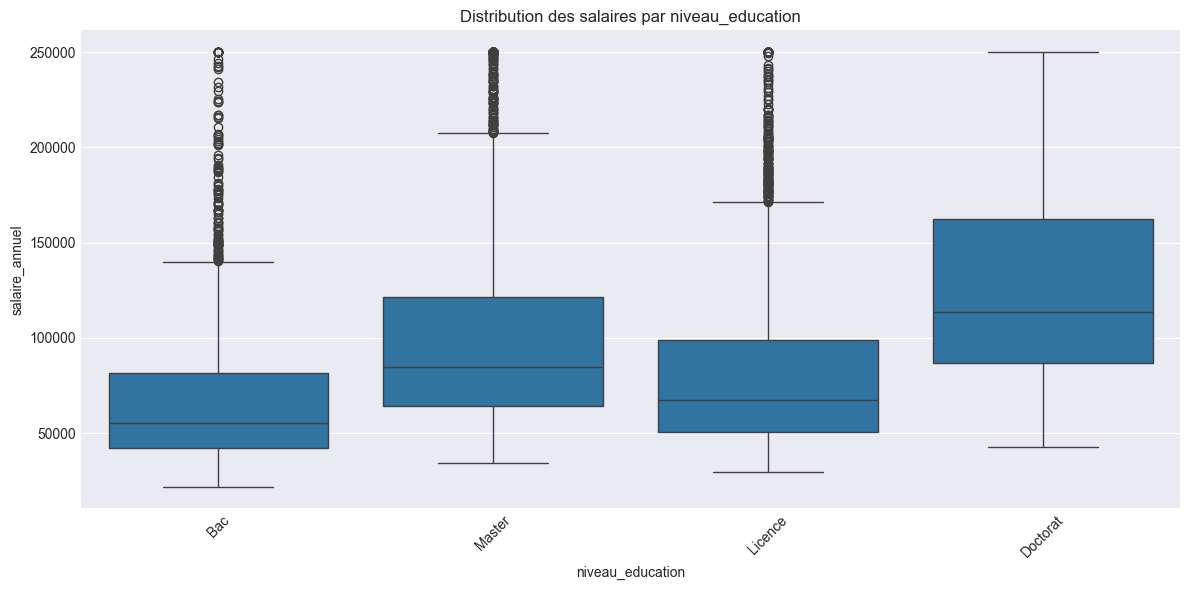

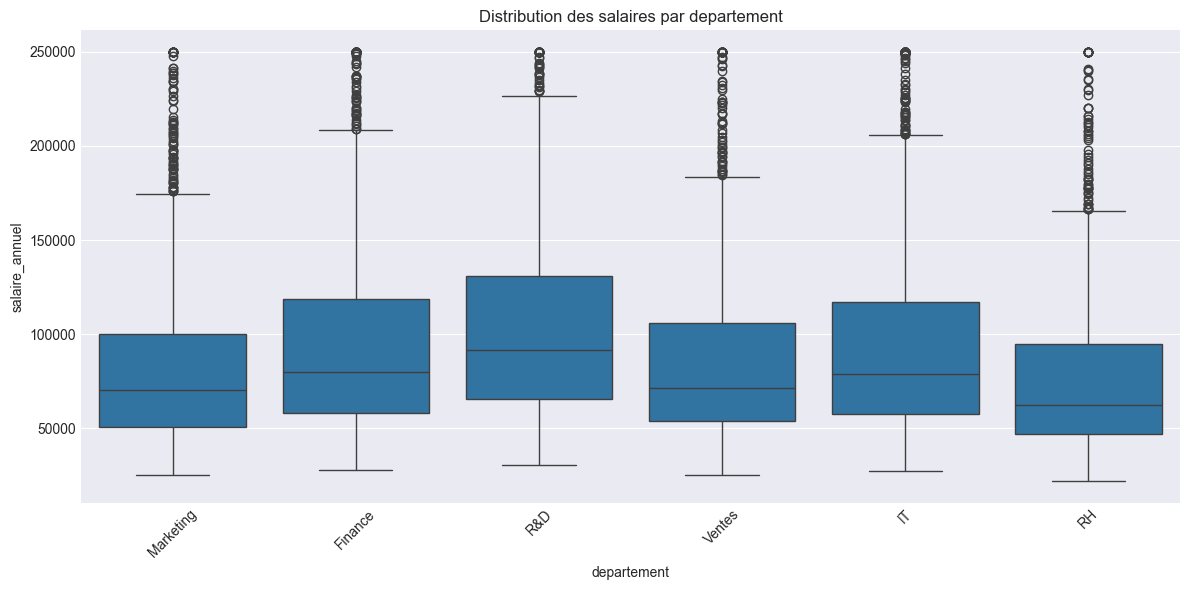

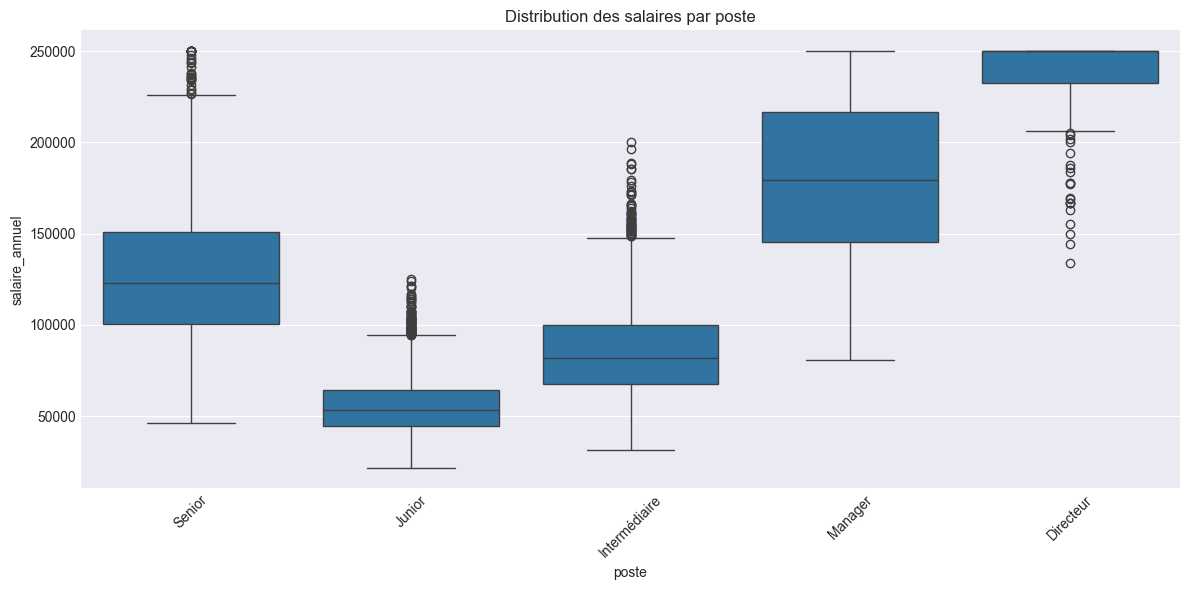

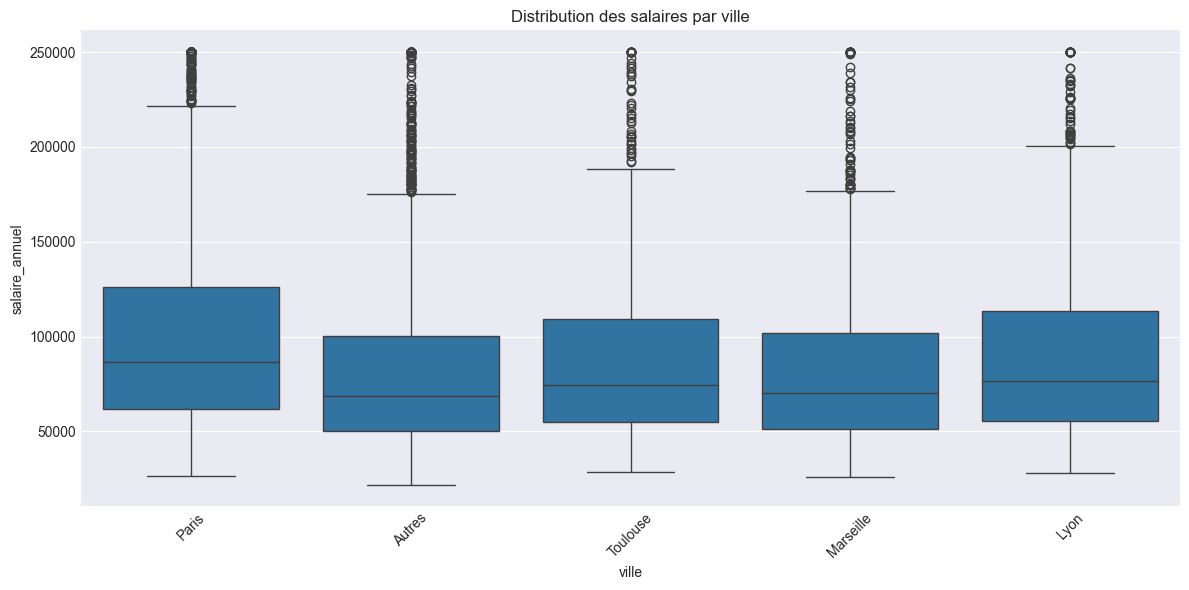

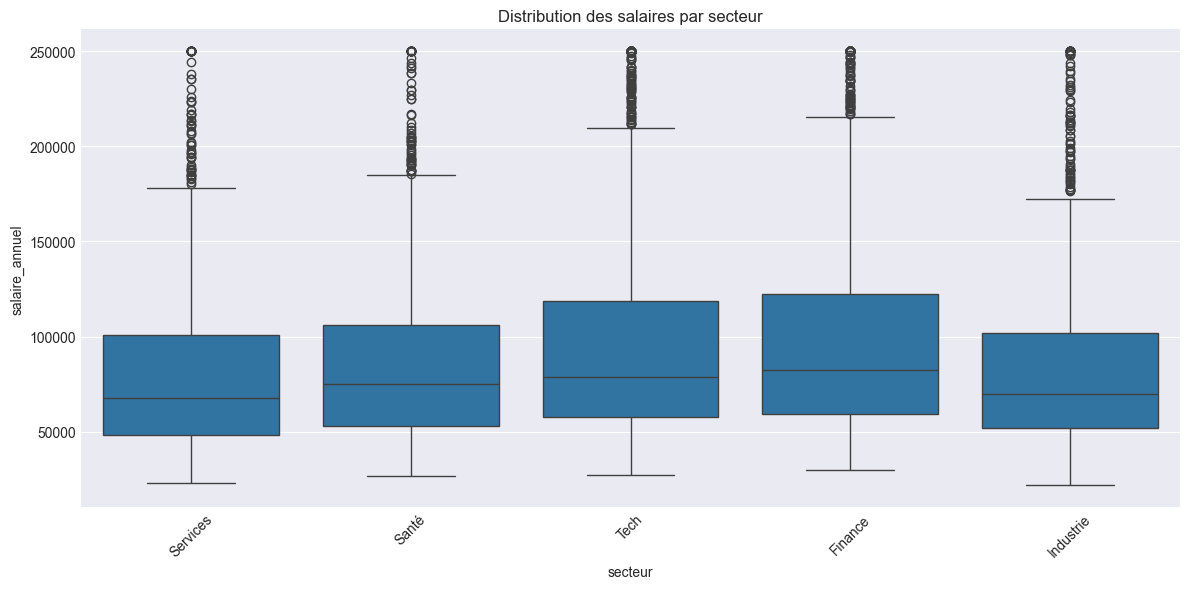

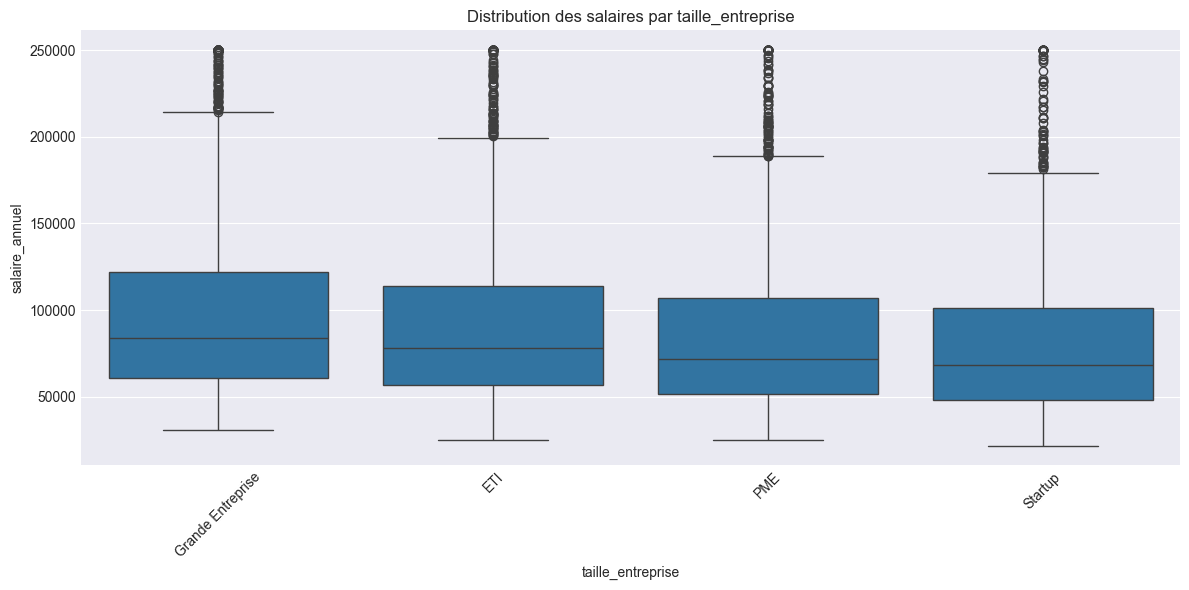

In [19]:
# Séparation des variables numériques et catégorielles

# TO DO : créer deux listes qui séparent les variables numériques et catégorielles
# Séparation des variables numériques et catégorielles
numeric_features = ['age', 'experience', 'education_years', 'heures_semaine', 
                   'nb_projets', 'evaluation_performance', 'anciennete_entreprise']
categorical_features = ['niveau_education', 'departement', 'poste', 'ville', 
                      'secteur', 'taille_entreprise']

# Analyse des données
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_features + ['salaire_annuel']].corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation des variables numériques')
plt.tight_layout()
plt.show()

# Histogrammes des variables numériques
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_features + ['salaire_annuel']):
    sns.histplot(data=df, x=col, ax=axes[idx])
    axes[idx].set_title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

# Boxplots des variables catégorielles vs salaire
for cat_feature in categorical_features:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x=cat_feature, y='salaire_annuel')
    plt.xticks(rotation=45)
    plt.title(f'Distribution des salaires par {cat_feature}')
    plt.tight_layout()
    plt.show()

# Séparation features et target
X = df[numeric_features + categorical_features]
y = df['salaire_annuel']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Analyse des données

# TO DO : Analyser les données avec des visualisations appropriées (histogrammes, boxplots, heatmap de corrélation, etc.) 
# pour comprendre la distribution des variables et leurs relations avec la variable cible 'salaire'

# Analyse des données
# Création des transformers pour les variables numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Création du preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Création du pipeline complet avec le modèle
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor(strategy='mean'))
])

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation des performances
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Performance du modèle de base (DummyRegressor):")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

Performance du modèle de base (DummyRegressor):
RMSE: 50331.48
R2 Score: -0.00


## 2. Préparation des Données

### 2.1 Séparation des features et de la cible

In [6]:
# Séparation des features (X) et de la cible (y)

# Séparer les données en dataset de features (X) et dataset de cible (y)

In [7]:
# Division en ensemble d'entraînement et de test (80/20)

# Spliter les données en ensembles d'entraînement et de test (80/20) et utiliser l'arribut random_state=42 

### 2.2 Preprocessing Pipeline

Nous allons créer un pipeline de preprocessing qui:
1. Impute les valeurs manquantes pour les variables numériques
2. Applique le scaling sur les variables numériques
3. Applique le one-hot encoding sur les variables catégorielles

In [8]:
# TO DO : implémenter des stratégie de prétraitement des données numériques et catégorielles en utilisant ColumnTransformer et Pipeline

## 3. Modélisation

### 3.1 Modèle de Base - DummyRegressor

In [9]:
# TO DO : Entrainer un modèle DummyRegressor, qui servira de baseline, et évaluer ses performances sur l'ensemble de test

### 3.2 Régression Linéaire Simple

In [10]:
# TO DO : Entrainer un modèle de régression linaire

In [11]:
# TO DO : afficher les valeurs prédites par le modèle linéaire vs les valeurs réelles du dataset de test

In [12]:
# TO DO : afficher les valeurs des coefficients du modèle linéaire

## 4. Régularisation avec GridSearchCV

In [13]:
# TO DO : Entrainer un modèle Ridge en testant les hyerparamètres suivants : 
#    - 'alpha': np.logspace(-3, 2, 20),
#    - 'selection': ['cyclic', 'random']
# Afficher les résultats de la cross validation et les performances sur l'ensemble de test 

In [14]:
# TO DO : Entrainer un modèle Ridge en testant les hyerparamètres suivants : 
#    - 'alpha': np.logspace(-3, 3, 20),
#    - 'solver': ['auto', 'svd', 'cholesky', 'lsqr']
# Afficher les résultats de la cross validation et les performances sur l'ensemble de test

## 5. Résumé et Comparaison Finale

In [15]:
# TO : Afficher pour chaque modèle (dummy, linéaire, ridge, lasso) les performances sur l'ensemble d'entrainement et de test et conclure
# sur le choix du modèle et sa capacité de généralisation